In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time

%matplotlib inline

## Distillation Class

In [2]:
class Distiller(tf.keras.Model):
  def __init__(self, teacher, student):
      super(Distiller, self).__init__()
      
      # Attributs de la classe Distiller
      self.teacher = teacher
      self.student = student
      
  # Compilation du model
  def compile( self, optimizer, metrics, distillation_loss_fn, student_loss_fn, alpha = 0.1, temperature= 20):

    super(Distiller,self).compile(optimizer = optimizer, metrics= metrics )
    # losses
    self.distillation_loss_fn = distillation_loss_fn
    self.student_loss_fn = student_loss_fn

    # Hyperparameters
    self.temperature = temperature
    self.alpha = alpha
  
  # Training Step
  def train_step(self, data):
    # Unpack data
    x, y = data

    # Forward pass of teacher
    teacher_predictions = self.teacher(x, training=False)
    with tf.GradientTape() as tape:
      # student forward
      student_predictions = self.student(x, training= True)

      # Compute losses
      student_loss = self.student_loss_fn(y, student_predictions)
      distillation_loss = self.distillation_loss_fn(
          tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
          tf.nn.softmax(student_predictions / self.temperature, axis=1),
        )

      loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

    # Compute gradients
    trainable_vars = self.student.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    # Update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Update the metrics configured in `compile()`.
    self.compiled_metrics.update_state(y, student_predictions)

    # Return a dict of performance
    results = {m.name: m.result() for m in self.metrics}
    results.update(
        {"student_loss": student_loss, "distillation_loss": distillation_loss}
    )
    return results

  # Test Step
  def test_step(self, data):
    
    # Unpack the data
    x, y = data

    # Compute predictions
    y_prediction = self.student(x, training=False)

    # Calculate the loss
    student_loss = self.student_loss_fn(y, y_prediction)

    # Update the metrics.
    self.compiled_metrics.update_state(y, y_prediction)

    # Return a dict of performance
    results = {m.name: m.result() for m in self.metrics}
    results.update({"student_loss": student_loss})
    return results


## Ploting history fonction

In [3]:
def plot_hist(los1,los2, accur1, accur2):
  plt.figure(figsize= (20,7))
  plt.subplot(121)
  plt.plot(accur1, label='KD Accuracy')
  plt.plot(accur2, label= 'Scratch Accuracy')

  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.legend()


  plt.subplot(122)
  plt.plot(los1, label='KD Loss')
  plt.plot(los2,  label= 'Scratch Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  plt.grid()
  plt.legend()
  plt.show()


## Loading and processing Data

In [4]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()


# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

170508288/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)


## Loading MobileNet

In [5]:
# Teacher Model
base_model = tf.keras.applications.mobilenet.MobileNet(
    input_shape=(32,32, 3), alpha=1.0, depth_multiplier=1, dropout=0.001,
    include_top=False, weights=None, input_tensor=None, pooling=None,
    classes=10, classifier_activation='softmax')

x = base_model.output
x = tf.keras.layers.Flatten()(x)
output = tf.keras.layers.Dense(10, activation="softmax")(x)
teacher = tf.keras.Model(inputs=base_model.input, outputs=output)


## Training MobileNet on Mnist Data

In [6]:
Epochs = 50
Batch = 32

In [7]:
# Train teacher as usual
teacher.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
teacher.summary()

# Train and evaluate teacher on data.
Teacher_hist = teacher.fit(x_train, y_train, epochs=Epochs, batch_size = Batch)
teacher.evaluate(x_test, y_test)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 16, 16, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 16, 16, 32)       128       
 ation)                                                      

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1563/1563 [==============================] - 50s 24ms/step - loss: 1.8926 - sparse_categorical_accuracy: 0.3058
Epoch 2/50
1563/1563 [==============================] - 37s 24ms/step - loss: 1.5647 - sparse_categorical_accuracy: 0.4396
Epoch 3/50
1563/1563 [==============================] - 37s 24ms/step - loss: 1.4015 - sparse_categorical_accuracy: 0.5041
Epoch 4/50
1563/1563 [==============================] - 37s 24ms/step - loss: 1.2502 - sparse_categorical_accuracy: 0.5612
Epoch 5/50
1563/1563 [==============================] - 38s 24ms/step - loss: 1.1677 - sparse_categorical_accuracy: 0.5980
Epoch 6/50
1563/1563 [==============================] - 38s 24ms/step - loss: 1.0634 - sparse_categorical_accuracy: 0.6326
Epoch 7/50
1563/1563 [==============================] - 42s 27ms/step - loss: 0.9307 - sparse_categorical_accuracy: 0.6778
Epoch 8/50
1563/1563 [==============================] - 42s 27ms/step - loss: 0.8573 - sparse_categorical_accuracy: 0.7023
Epoch 9/50
1563/1563 [=====

[1.147588849067688, 0.7537999749183655]

No handles with labels found to put in legend.


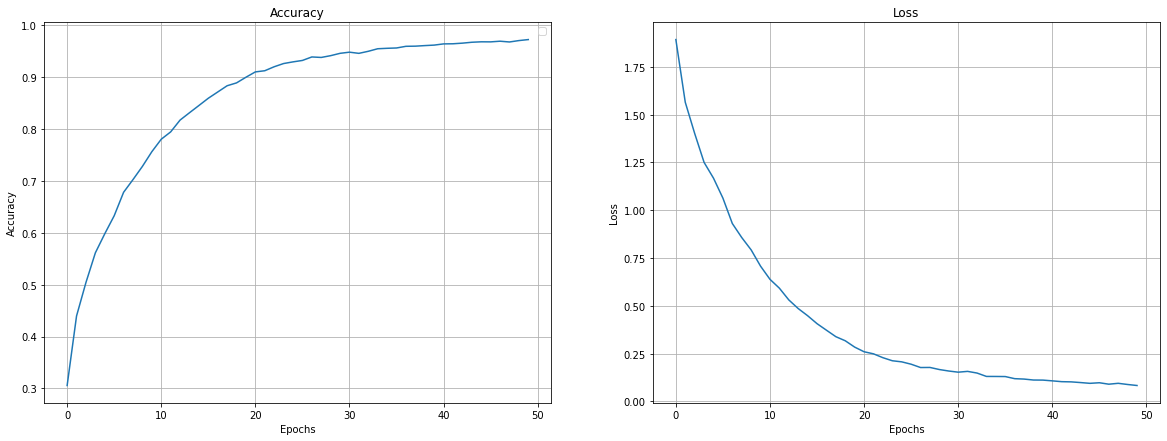

In [9]:
#History
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(Teacher_hist.history['sparse_categorical_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy")
plt.grid()
plt.legend()


plt.subplot(122)
plt.plot(Teacher_hist.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss")
plt.grid()

plt.show()

In [10]:
# MobileNet Model
def MobileNet(Alpha = 1.0):
  base_model = tf.keras.applications.mobilenet.MobileNet(
    input_shape=(32,32, 3), alpha= Alpha, depth_multiplier=1, dropout=0.001,
    include_top=False, weights=None, input_tensor=None, pooling=None,
    classes=10, classifier_activation='softmax')

  x = base_model.output
  x = tf.keras.layers.Flatten()(x)
  output = tf.keras.layers.Dense(10, activation="softmax")(x)
  model = tf.keras.Model(inputs=base_model.input, outputs=output)
  return model

## Knowledge Distillation

In [11]:
# Create the student
student = MobileNet(0.25)
student.summary()

# Clone student for later comparison
student_scratch = tf.keras.models.clone_model(student)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 8)         216       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 16, 16, 8)        32        
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 8)         0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 8)        72        
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 16, 16, 8)        32        
 ation)                                                    

## Training from Scratch

In [12]:
Epochs = 100
Batch = 32

In [13]:
# Training studen model from scratch
student_scratch.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
  )

t1 = time.time()
scrratch_stud_hist = student_scratch.fit(x_train, y_train, epochs=Epochs, batch_size = Batch)
t2 = time.time()
time_scratch = t2 - t1

# Evaluate student on test dataset
student_scratch.evaluate(x_test, y_test)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1563/1563 [==============================] - 28s 16ms/step - loss: 2.1257 - sparse_categorical_accuracy: 0.2030
Epoch 2/100
1563/1563 [==============================] - 31s 20ms/step - loss: 1.8222 - sparse_categorical_accuracy: 0.3166
Epoch 3/100
1563/1563 [==============================] - 32s 21ms/step - loss: 1.6564 - sparse_categorical_accuracy: 0.3892
Epoch 4/100
1563/1563 [==============================] - 33s 21ms/step - loss: 1.5351 - sparse_categorical_accuracy: 0.4436
Epoch 5/100
1563/1563 [==============================] - 24s 15ms/step - loss: 1.4510 - sparse_categorical_accuracy: 0.4782
Epoch 6/100
1563/1563 [==============================] - 24s 15ms/step - loss: 1.3795 - sparse_categorical_accuracy: 0.5035
Epoch 7/100
1563/1563 [==============================] - 24s 15ms/step - loss: 1.3178 - sparse_categorical_accuracy: 0.5265
Epoch 8/100
1563/1563 [==============================] - 24s 15ms/step - loss: 1.2687 - sparse_categorical_accuracy: 0.5436
Epoch 9/100
1563/156

[1.3035622835159302, 0.6470999717712402]

# Knowledge Distillation


## Determiner le patamètre de température $T$

In [14]:
# Paramètres d'entrainement
Epochs = 5
Batch = 32

#Variables
T = np.arange(1, 51,5 )
accur = []
loss = []


for t in T:
  # Create the student
  student = MobileNet(0.25)

  dist = Distiller(teacher, student)
  dist.compile(
      optimizer = tf.keras.optimizers.Adam(),
      metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
      distillation_loss_fn = tf.keras.losses.KLDivergence(),
      student_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      alpha = 0.1,
      temperature = t)


  # Distill teacher to student
  dist.fit(x_train, y_train, epochs=Epochs, batch_size = Batch)
  
  # Evaluate student on test dataset
  score = dist.evaluate(x_test, y_test)

  # Storing information
  accur.append(score[0])
  loss.append(score[1])



Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1563/1563 [==============================] - 39s 22ms/step - sparse_categorical_accuracy: 0.1711 - student_loss: 2.2238 - distillation_loss: 0.0674
Epoch 2/5
1563/1563 [==============================] - 33s 21ms/step - sparse_categorical_accuracy: 0.2815 - student_loss: 1.9505 - distillation_loss: 0.0618
Epoch 3/5
1563/1563 [==============================] - 33s 21ms/step - sparse_categorical_accuracy: 0.3510 - student_loss: 1.7876 - distillation_loss: 0.0576
Epoch 4/5
1563/1563 [==============================] - 34s 22ms/step - sparse_categorical_accuracy: 0.3985 - student_loss: 1.6636 - distillation_loss: 0.0541
Epoch 5/5
313/313 [==============================] - 3s 7ms/step - sparse_categorical_accuracy: 0.4282 - student_loss: 1.6141
Epoch 1/5
1563/1563 [==============================] - 36s 21ms/step - sparse_categorical_accuracy: 0.1971 - student_loss: 2.1364 - distillation_loss: 0.0012
Epoch 2/5
1563/1563 [==============================] - 33s 21ms/step - sparse_categorical_accu

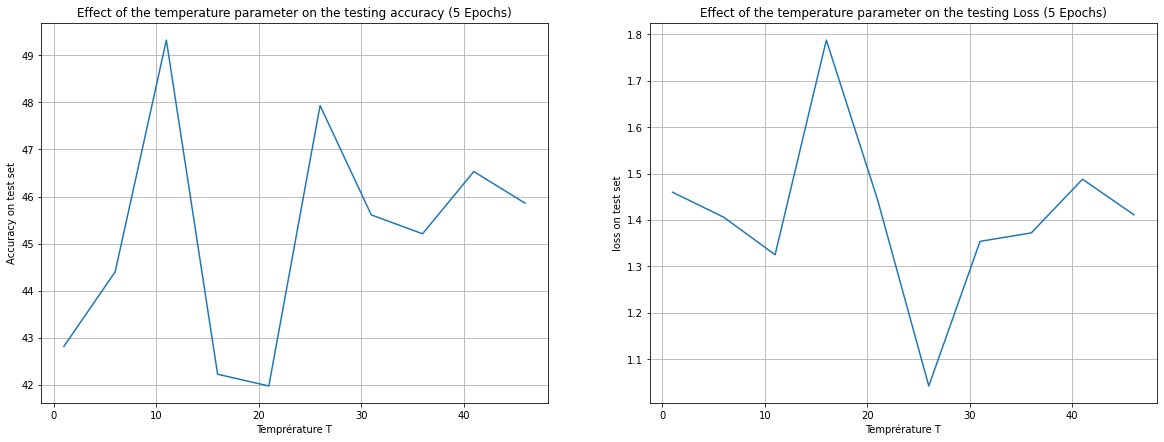

In [16]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(T, np.array(accur)* 100)
plt.xlabel('Temprérature T')
plt.ylabel("Accuracy on test set")
plt.title("Effect of the temperature parameter on the testing accuracy (5 Epochs)")
plt.grid()

plt.subplot(122)
plt.plot(T, np.array(loss))
plt.xlabel('Temprérature T')
plt.ylabel("loss on test set")
plt.title("Effect of the temperature parameter on the testing Loss (5 Epochs)")
plt.grid()

plt.show()

In [21]:
t_opti = T[np.argmax(accur)]
print("Valeur optimale du paramètre T : ", t_opti)

Valeur optimale du paramètre T :  11


## Entrainement par KD

In [23]:
# Paramètre d'entrainement
Epochs = 100
Batch = 32

# Construction du distilleur
student = MobileNet(0.25)
dist = Distiller(teacher, student)
dist.compile(
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
    distillation_loss_fn = tf.keras.losses.KLDivergence(),
    student_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    alpha = 0.1,
    temperature = t_opti)


# Distill teacher to student
t1 = time.time()
dist_hist = dist.fit(x_train, y_train, epochs=Epochs, batch_size = Batch)
t2 = time.time()
time_dist = t2 - t1

# Evaluate student on test dataset
dist.evaluate(x_test, y_test)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1563/1563 [==============================] - 38s 22ms/step - sparse_categorical_accuracy: 0.1597 - student_loss: 2.2501 - distillation_loss: 3.6668e-04
Epoch 2/100
1563/1563 [==============================] - 36s 23ms/step - sparse_categorical_accuracy: 0.2764 - student_loss: 1.9227 - distillation_loss: 3.3525e-04
Epoch 3/100
1563/1563 [==============================] - 34s 22ms/step - sparse_categorical_accuracy: 0.3616 - student_loss: 1.7193 - distillation_loss: 3.0985e-04
Epoch 4/100
1563/1563 [==============================] - 33s 21ms/step - sparse_categorical_accuracy: 0.4190 - student_loss: 1.5812 - distillation_loss: 2.8850e-04
Epoch 5/100
1563/1563 [==============================] - 34s 22ms/step - sparse_categorical_accuracy: 0.4691 - student_loss: 1.4628 - distillation_loss: 2.6860e-04
Epoch 6/100
1563/1563 [==============================] - 35s 22ms/step - sparse_categorical_accuracy: 0.5083 - student_loss: 1.3657 - distillation_loss: 2.5213e-04
Epoch 7/100
1563/1563 [=====

[0.6503999829292297, 0.9307929277420044]

## Evaluating both performances

In [27]:
def plot_hist2(teacher, student_KD, student_scratch):

  # Definir les variables
  accur1 = student_KD.history['sparse_categorical_accuracy'] 
  accur2 = student_scratch.history['sparse_categorical_accuracy'] 
  accur3 = teacher.history['sparse_categorical_accuracy'] 

  los1 = student_KD.history['student_loss']
  los2 = student_scratch.history['loss']
  los3 = teacher.history['loss']

  # Plot
  plt.figure(figsize= (20,7))
  plt.subplot(121)
  plt.plot(accur1, label='KD Accuracy')
  plt.plot(accur2, label= 'Scratch Accuracy')
  plt.plot(accur3, label= 'Teacher Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.legend()


  plt.subplot(122)
  plt.plot(los1, label='KD Loss')
  plt.plot(los2,  label= 'Scratch Loss')
  plt.plot(los3, label= 'Teacher Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.grid()
  plt.legend()

  plt.show()

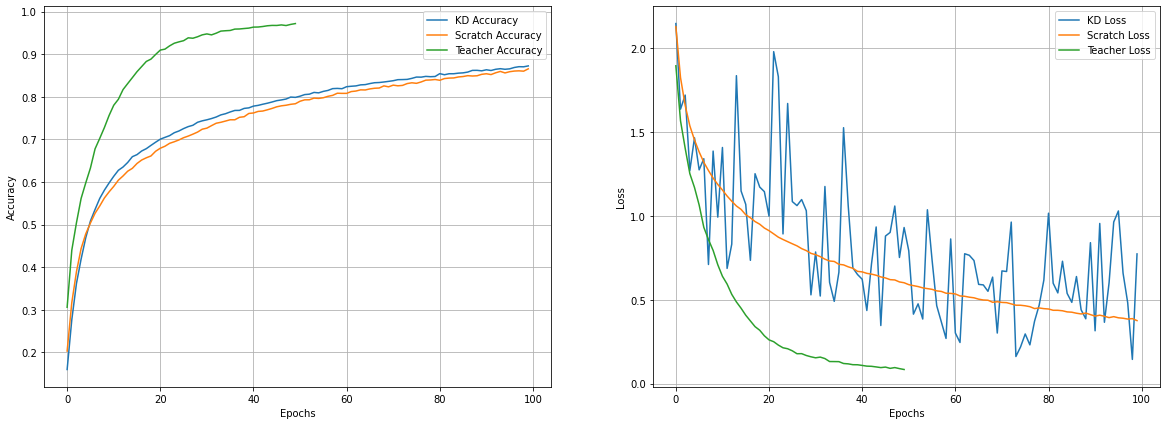

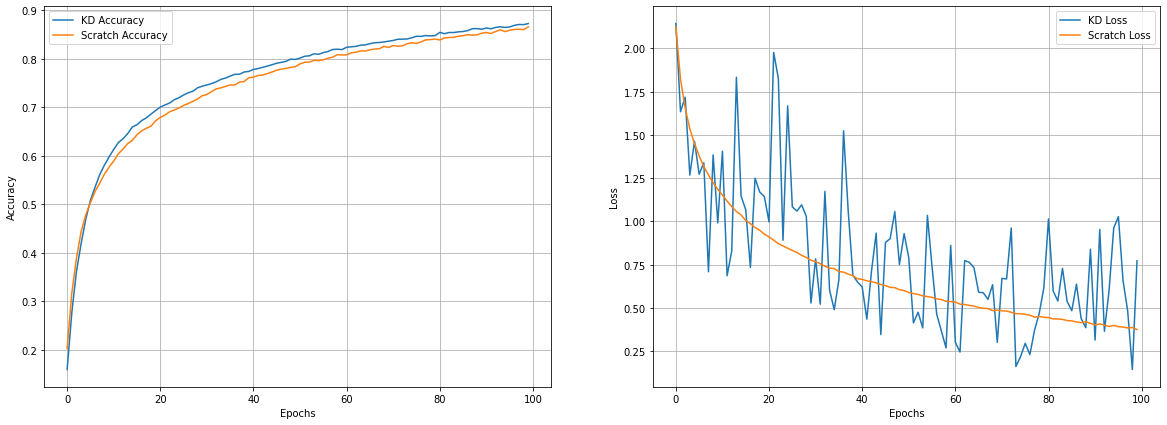

In [29]:
plot_hist2(Teacher_hist, dist_hist, scrratch_stud_hist)
plot_hist(dist_hist.history['student_loss'], scrratch_stud_hist.history['loss'] ,dist_hist.history['sparse_categorical_accuracy'] , scrratch_stud_hist.history['sparse_categorical_accuracy'])

## Performances

In [34]:
print("Training Time :")
print(" Knowledge Distillation :", time_dist // 60,'Min', time_dist - (time_dist // 60)*60,"s")
print(" Training from Scratch :", time_scratch // 60 ,"Min", time_scratch - (time_scratch // 60) * 60, "s")
print("")

Compression_ratio = teacher.count_params()/ student.count_params()
print("Estimation des paramètres mémoire :")
print(" Ratio de compression :", Compression_ratio )
print(" Compression effectuée : ", (teacher.count_params()*4)/1e6, "Mo à ", (student.count_params()*4) /1e6 ,"Mo"  )
print("")

print("Accuracy on test set: ")
print(" Teacher accuracy ", teacher.evaluate(x_test, y_test)[1])
print(" KD Student accuracy ", dist.evaluate(x_test, y_test)[0])
print(" Scratch Student accuracy ", student_scratch.evaluate(x_test, y_test)[1])

Training Time :
 Knowledge Distillation : 56.0 Min 26.33417820930481 s
 Training from Scratch : 43.0 Min 26.427648067474365 s

Estimation des paramètres mémoire :
 Ratio de compression : 14.649067901625406
 Compression effectuée :  12.956456 Mo à  0.884456 Mo

Accuracy on test set: 
313/313 [==============================] - 5s 15ms/step - loss: 1.1476 - sparse_categorical_accuracy: 0.7538
 Teacher accuracy  0.7537999749183655
313/313 [==============================] - 2s 7ms/step - sparse_categorical_accuracy: 0.6504 - student_loss: 1.2759
 KD Student accuracy  0.6503999829292297
313/313 [==============================] - 2s 7ms/step - loss: 1.3036 - sparse_categorical_accuracy: 0.6471
 Scratch Student accuracy  0.6470999717712402


In [ ]:
S